# Проверка корректности проведения A/B теста

## Техническое задание
- Название теста - **recommender_system_test**
- группы:
    * А - контрольная
    * В - новая платёжная воронка
- дата запуска - *2020-12-07*
- дата остановки набора пользователей - *2020-12-21*
- дата остановки - *2021-01-04*
- аудитория - 15% новых пользователей региона **EU**
- назначение теста - тестирование изменений, связанных с внедрением улучшенной рекомендательной системы
- ожидаемое количество участников - *6000*
- ожидаемый эффект - за *14* дней с момента регистрации пользователи покажут улучшение кажой метрики не менее, чем на *10%*:
    * просмотр карточек товаров (*product_page*)
    * просмотр корзины (*product_cart*)
    * покупка (*purchase*)

## Структура
1. [Начало](#inception)
1. [Предобработка](#preprocessing)
1. [EDA](#eda)
1. [Гипотезы](#hypothesis)
1. [Выводы](#conclusions)

---

## Начало работы
<a name='inception' id='inception'></a>
Импортируем библиотеки, считаем данные

In [1]:
!pip install pandas seaborn --upgrade -q

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import os

from scipy import stats as st

from warnings import filterwarnings 
filterwarnings('ignore')

In [3]:
pd.set_option(
    'display.float_format', lambda x: '%.3f' % x
)

sns.set(
    rc = {
        'figure.figsize': (17, 7),
        'figure.dpi': 80,
        'axes.grid': True,
        'axes.grid.axis': 'x',
        'axes.grid.which': 'both',
        'grid.alpha': .4,
        'xtick.minor.visible': True,
        },
    palette = 'colorblind',
    style = 'ticks'
)

In [4]:
LOCAL_PATH = '/datasets'
NEW_USERS_DATE_RANGE = pd.date_range('2020-12-07', '2020-12-21')
TEST_DATE_RANGE = pd.date_range('2020-12-07', '2021-01-04')

In [5]:
def read_csv(func: "pd.read_csv" = pd.read_csv) -> pd.DataFrame:
    """Wrapper for pd.read_csv."""

    def wrapper(*args, **kwargs: "pd.read_csv parameters") -> pd.DataFrame:
        """
        Return a DataFrame from csv with true and ordered columns and sort by
        datetime, and display 5 randow rows and df.info().
        """
        df = func(*args, **kwargs)

        if kwargs.get("names", None) is None:
            df.columns = [
                re.sub("([a-z])([A-Z]+)", r"\1_\2", col)
                .strip()
                .lower()
                .replace(" ", "_")
                for col in df.columns
            ]

        parse_dates = kwargs.get("parse_dates", None)
        if parse_dates is not None and df.select_dtypes("datetime").isnull:
            df.iloc[:, parse_dates[0]] = pd.to_datetime(
                df.iloc[:, parse_dates[0]], unit="s"
            )

        if not df.select_dtypes("datetime").isnull:
            date_column = df.select_dtypes("datetime").columns[0]
            df = df.sort_values(date_column).reset_index(drop=True)

        columns_indeces = kwargs.get("usecols", np.arange(df.shape[1]))
        df = df.iloc[:, columns_indeces]

        dtypes = df.dtypes.unique()
        
        display(df.sample(5, random_state=42).sort_index())
        print("---------------------------------")
        for dtype in dtypes:
            print(f'describe для {dtype}')
            display(df.select_dtypes(dtype).describe())
        print("---------------------------------")
        df.info(memory_usage="deep")

        return df

    return wrapper


true_read_csv = read_csv()

Пользователи:

In [6]:
PATH = os.environ.get('NEW_USERS', f'{LOCAL_PATH}/final_ab_new_users.csv')

users = true_read_csv(
    filepath_or_buffer = PATH,
    parse_dates = [1]
)

,user_id,first_date,region,device
17063,3F6B817BBAD660EB,2020-12-21,CIS,Mac
28700,486F743845EA72F5,2020-12-09,EU,Android
39514,7879260D030DEA35,2020-12-11,EU,Android
48038,A26522355BF18795,2020-12-12,EU,Android
58723,8FE6B7855247D76D,2020-12-20,EU,Android


---------------------------------
describe для object


,user_id,region,device
count,61733,61733,61733
unique,61733,4,4
top,D72A72121175D8BE,EU,Android
freq,1,46270,27520


describe для datetime64[ns]


,first_date
count,61733
unique,17
top,2020-12-21 00:00:00
freq,6290
first,2020-12-07 00:00:00
last,2020-12-23 00:00:00


---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 12.0 MB


Пользователи не дублируются, 4 региона (целевой *EU* самый частый), 4 устройства, даты немного выходят за диапазон. Пропусков нет.

События:

In [7]:
PATH = os.environ.get('EVENTS', f'{LOCAL_PATH}/final_ab_events.csv')

events = true_read_csv(
    filepath_or_buffer = PATH,
    parse_dates = [1],
)

,user_id,event_dt,event_name,details
39945,A157AAA506AA21C3,2020-12-21 21:41:19,purchase,4.990
50693,3F0E9ABE2DB30444,2020-12-23 04:37:13,purchase,4.990
204789,E72CAC67E18A2A6B,2020-12-21 11:34:53,product_page,NaN
218582,D6CDDC77A39840F8,2020-12-22 04:00:50,product_page,NaN
372358,B628EB26058A769A,2020-12-21 12:47:49,login,NaN


---------------------------------
describe для object


,user_id,event_name
count,440317,440317
unique,58703,4
top,A3917F81482141F2,login
freq,36,189552


describe для datetime64[ns]


,event_dt
count,440317
unique,267268
top,2020-12-23 02:37:24
freq,10
first,2020-12-07 00:00:33
last,2020-12-30 23:36:33


describe для float64


,details
count,62740.000
mean,23.878
std,72.180
min,4.990
25%,4.990
50%,4.990
75%,9.990
max,499.990


---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 64.8 MB


Диапазон дат не дотягивает до нужного (данные не полные), пропуски в поле *details* (не для всех событий есть дополнительные данные, не критично)

Маркетинговые события:

In [8]:
PATH = os.environ.get('MARKETING_EVENTS', f'{LOCAL_PATH}/ab_project_marketing_events.csv')

marketing_events = true_read_csv(
    filepath_or_buffer = PATH,
    parse_dates = [2, 3],
    usecols = [2, 3, 0, 1]
)

,start_dt,finish_dt,name,regions
0,2020-12-25,2021-01-03,Christmas&New Year Promo,"EU, N.America"
5,2020-11-26,2020-12-01,Black Friday Ads Campaign,"EU, CIS, APAC, N.America"
9,2020-05-09,2020-05-11,Victory Day CIS (May 9th) Event,CIS
11,2020-06-25,2020-07-01,Dragon Boat Festival Giveaway,APAC
12,2020-11-11,2020-11-12,Single's Day Gift Promo,APAC


---------------------------------
describe для datetime64[ns]


,start_dt,finish_dt
count,14,14
unique,14,14
top,2020-12-25 00:00:00,2021-01-03 00:00:00
freq,1,1
first,2020-01-25 00:00:00,2020-02-07 00:00:00
last,2020-12-30 00:00:00,2021-01-07 00:00:00


describe для object


,name,regions
count,14,14
unique,14,6
top,Christmas&New Year Promo,APAC
freq,1,4


---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   start_dt   14 non-null     datetime64[ns]
 1   finish_dt  14 non-null     datetime64[ns]
 2   name       14 non-null     object        
 3   regions    14 non-null     object        
dtypes: datetime64[ns](2), object(2)
memory usage: 2.4 KB


Всё в пределах нормы.

Участники теста:

In [9]:
PATH = os.environ.get('PARTICIPANTS', f'{LOCAL_PATH}/final_ab_participants.csv')

participants = true_read_csv(
    filepath_or_buffer = PATH
)

,user_id,group,ab_test
1570,F36F4FC5A884C3DA,A,recommender_system_test
3310,FDBCCC4C6B301DA1,A,recommender_system_test
4084,51B7F3ADA62C28CE,B,recommender_system_test
4525,1BC8D784255D5E67,A,recommender_system_test
15737,8FF91E21E27A330D,A,interface_eu_test


---------------------------------
describe для object


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 3.6 MB


Есть дублирующиеся пользователи (скорее всего, участвуют в обоих тестах), два эксперимента и две группы.

## Предобработка
<a name='preprocessing' id ='preprocessing'></a>
Почистим разный мусор

Для начала нужно отфильтровать пользователей. Условия нашего теста - начало набора *12-07*, остановка набора *12-21*, регион *EU*.

In [10]:
users = users[
    (users['region'] == 'EU')
    &(users['first_date'].isin(NEW_USERS_DATE_RANGE))
]

Тест - только *recommender_system_test*. Но сначала посмотрим, нет ли пользователей сразу в двух тестах:

In [11]:
(participants.groupby('user_id')['ab_test'].nunique() > 1).sum()

1602

Таких пользователей 1602 (в копилку нарушений). Вынесем их пока что в отдельную переменную, и забудем об этом:

In [12]:
two_test_ids = participants.groupby('user_id')['ab_test'].apply(
    lambda x: 1 if x.nunique() > 1 else 0
    )

In [13]:
participants = participants[
    participants['ab_test'] == 'recommender_system_test'
]

Возьмём только целевых пользователей (которые участвуют в нужном тесте):

In [14]:
targets = users.merge(participants[['user_id', 'group']], on='user_id')

И сразу проверим, какой процент целевых пользователей среди всех из региона *EU*:

In [15]:
targets['user_id'].nunique() / users['user_id'].nunique()

0.15

В требования к аудитории мы попали.
<br>
Проверим пользователей сразу в двух группах:

In [16]:
(targets.groupby('user_id')['group'].nunique() > 1).sum()

0

Объединим датасет с пользователями с датасетом с их действиями:

In [17]:
df = targets.merge(events, on='user_id', how='left')

И оставим только действия за первые 14 дней с момента регистрации:

In [18]:
df['delta'] = df['event_dt'] - df['first_date']

In [19]:
x = df.shape[0]
df['delta'] = df['event_dt'] - df['first_date']
df = df[df['delta'].isna()|(df['delta'] < pd.Timedelta('14D'))]
1 - df.shape[0] / x

0.030429821224800313

Удалилось 3% событий.

---

## EDA
<a name='eda' id='eda'></a>
Посмотрим на разные распределения и на результаты теста

Начнём с распределения среди целевых пользователей (размеры тестовой и контрольной групп, распределение устройств внутри групп, всё такое):

In [20]:
targets['group'].value_counts(normalize=True)

A   0.572
B   0.428
Name: group, dtype: float64

Распределение пользователей между тестовой и контрольной группами некорректное (в ту же копилку нарушений). Посмотрим на распределение устройств в обеих группах:

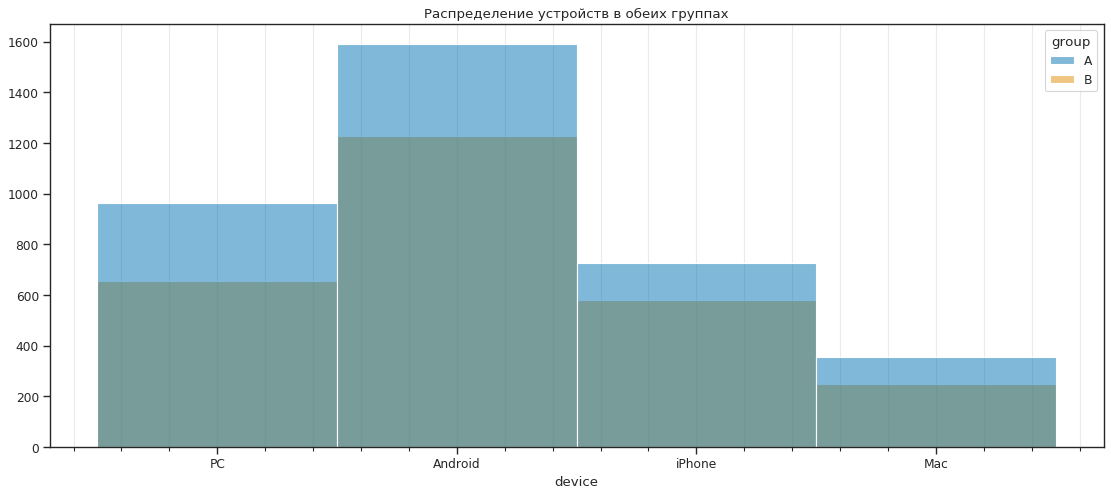

In [21]:
sns.histplot(
    data = targets,
    x = 'device',
    hue = 'group',
    )

plt.title('Распределение устройств в обеих группах')
plt.ylabel('')
plt.show()

Распределения в целом похожи, но сказывается перекос в сторону контрольной группы.
<br>
Посмотрим на действия пользователей:

In [22]:
df.isna().sum()

user_id           0
first_date        0
region            0
device            0
group             0
event_dt       2870
event_name     2870
details       22387
delta          2870
dtype: int64

In [23]:
df[df['event_dt'].isna()].groupby('group')['user_id'].nunique() / df.groupby('group')['user_id'].nunique()

group
A   0.283
B   0.677
Name: user_id, dtype: float64

67% пользователей из тестовой группы не совершили ни одной покупки за время теста, после этого в принципе можно перестать исследовать результаты теста, отправив его на перезапуск.
<br>
Посмотрим на маркетинговые события, которые могли дополнительно повлиять на качество теста (куда уж ещё больше):

In [24]:
marketing_events[
    marketing_events["regions"].str.contains("EU")
    & (
        (marketing_events["start_dt"].isin(TEST_DATE_RANGE))
        | (marketing_events["finish_dt"].isin(TEST_DATE_RANGE))
    )
]

,start_dt,finish_dt,name,regions
0,2020-12-25,2021-01-03,Christmas&New Year Promo,"EU, N.America"


Наш тест выпал на новый год и рождество, дела всё хуже и хуже)
<br>
Посмотрим на распределение регистраций и событий во времени по группам:

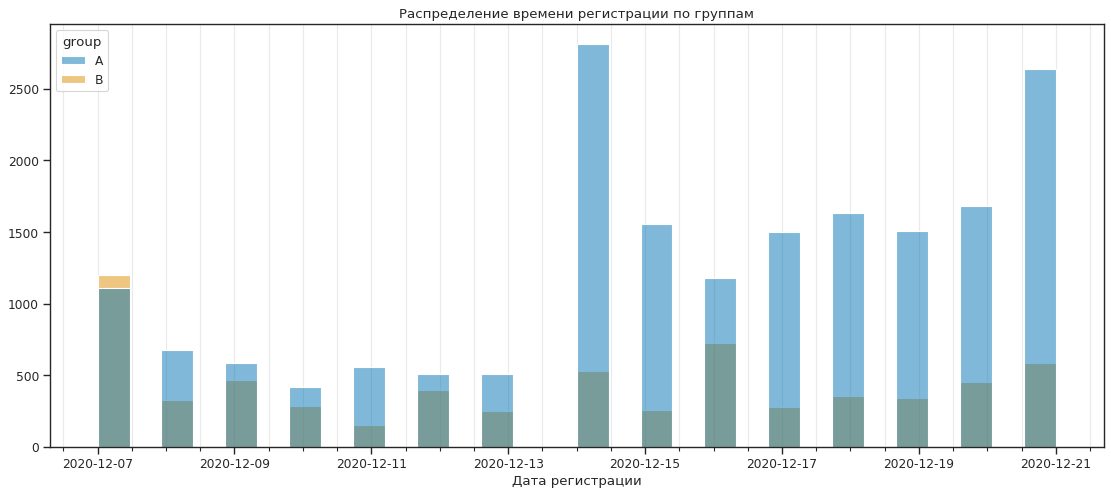

In [25]:
sns.histplot(
    data = df,
    x = 'first_date',
    hue = 'group'
)

plt.title('Распределение времени регистрации по группам')
plt.ylabel('')
plt.xlabel('Дата регистрации')
plt.show()

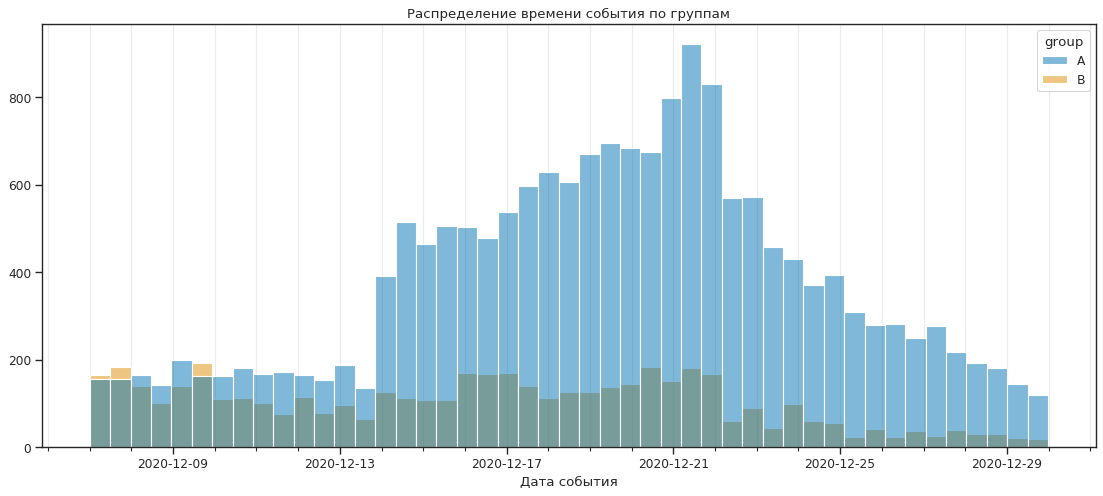

In [26]:
sns.histplot(
    data = df,
    x = 'event_dt',
    hue = 'group'
)

plt.title('Распределение времени события по группам')
plt.ylabel('')
plt.xlabel('Дата события')
plt.show()

В очередной раз видим, как всё плохо - в начале распределения были примерно одинаковые, но на второй неделе набора пользователей в тест что-то произошло и бо'льшая часть пользователей стала попадать в контрольную группу, что убило весь эксперимент.
<br>
Посмотрим на события. Сначала сделаем сводную таблицу с количеством событий в правильном порядке:

In [27]:
temp = (
    df.pivot_table(
        index = 'event_name',
        columns = 'group',
        values = 'user_id',
        aggfunc = 'nunique',
        margins = True,
        dropna = False,
        margins_name = 'registration'
    ).rename(columns={'registration': 'AB'})
     .reindex([
         'registration', 
         'login', 
         'product_page', 
         'product_cart', 
         'purchase'
         ]))

temp

group,A,B,AB
event_name,,,
registration,3634,2717,6351
login,2604,876,3480
product_page,1685,493,2178
product_cart,782,244,1026
purchase,833,249,1082


Посмотрим на конверсию в каждый шаг из регистрации:

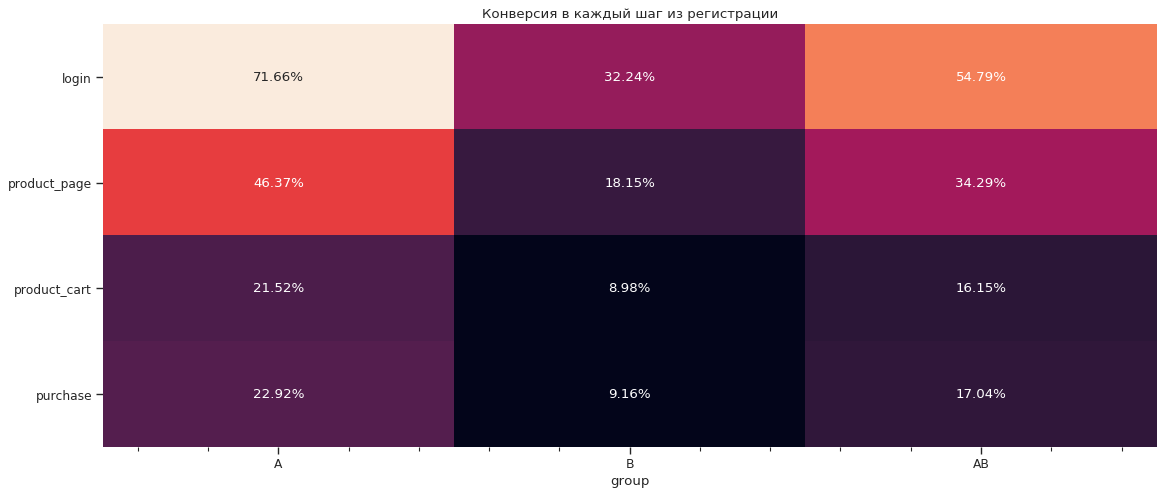

In [28]:
sns.heatmap(
    (temp / temp.loc['registration']).iloc[1:], 
    annot=True, 
    fmt='.2%', 
    cbar=None
)

plt.title('Конверсия в каждый шаг из регистрации')
plt.ylabel('')
plt.yticks(rotation=0)
plt.show()

In [29]:
temp.pct_change() 

group,A,B,AB
event_name,,,
registration,NaN,NaN,NaN
login,-0.283,-0.678,-0.452
product_page,-0.353,-0.437,-0.374
product_cart,-0.536,-0.505,-0.529
purchase,0.065,0.020,0.055


Положительные изменения на шаге покупки связаны, скорее всего, с возможностью купить товар в один клик (в обход корзины).
<br>
Проверим (зачем-то) различия в конверсии на стат.значимость.

---

## Гипотезы
<a name='hypothesis' id='hypothesis'></a>
Проверим гипотезы

$H_0 - {Конверсия\ в\ контрольной\ и\ тестовой\ группах\ не\ отличается}$
<br>
$H_1 - {Конверсия\ в\ контрольной\ и\ тестовой\ группах\ отличается}$
<br>
$\alpha = 5\%$

In [30]:
temp

group,A,B,AB
event_name,,,
registration,3634,2717,6351
login,2604,876,3480
product_page,1685,493,2178
product_cart,782,244,1026
purchase,833,249,1082


In [31]:
def two_sample_z_test(
    A: {'type': list, 'help': 'total and success counts from sample A'}, 
    B: {'type': list, 'help': 'total and success counts from sample B'}
    ) ->{'type': float, 'help': 'p-value for z-test'}:
    """Return p-value for two-sample z-test."""
    p1 = A[1] / A[0]
    p2 = B[1] / B[0]
    p = (A[1] + B[1]) / (A[0] + B[0])
    
    z_value = (p1 - p2) / np.sqrt(p * (1 - p) * (1/A[0] + 1/B[0]))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    return p_value

In [32]:
for event in temp.index[1:]:
    A = [
        temp.loc['registration', 'A'], 
        temp.loc[event, 'A']
        ]
    B = [
        temp.loc['registration', 'B'], 
        temp.loc[event, 'B']
    ]
    print(f'p-value для {event}: {two_sample_z_test(A, B)}')

p-value для login: 0.0
p-value для product_page: 0.0
p-value для product_cart: 0.0
p-value для purchase: 0.0


P-value крайне мал, даже без поправки на множественное тестирование можно отклонить нулевую гипотезу о равенстве конверсий и сделать вывод о значительных отличиях.

---

## Выводы
<a name='conclusions' id='conclusions'></a>
Подведём итоги

Тест был проведён с огромным количеством и его нужно перезапускать, какие-то выводы по нему делать нельзя.
- В датасете отсутствуют любые события за *2021-01-01 - 2021-01-03*
- Одновременно проходил другой тест, с которым есть пересечение по пользователям
- Последняя неделя теста выпала на рождество и новый год, что тоже является недопустимым
- Не равные тестовая и контрольная группа

Стоит проанализировать ошибки, исправить их и перезапустить тест, чтобы можно было проанализировать результаты.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=73c6fdc9-2380-4d92-b495-95da9dd36eb1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>